In [1]:
import time
import json
from decimal import Decimal
from datetime import datetime
# Third parties libs
from web3 import Web3
from requests import HTTPError
# Utils
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
w3 = Web3(Web3.HTTPProvider('https://eth-mainnet-public.unifra.io'))

In [4]:
TOKEN_ADDR = '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48'
TOKEN_CREATION_BLOCK = 12254697
TOKEN_DECIMALS = 6

contract_abi = []
with open('token_abi.json', 'r') as fh:
    contract_abi = json.load(fh)

In [5]:
contract = w3.eth.contract(
    address=TOKEN_ADDR,
    abi=contract_abi
)

### Helper functions

In [6]:
def fromUnits(weiAmount, decimals):
    return Decimal(weiAmount) / Decimal(10 ** decimals)

In [7]:
def fetch_chunk(contract_event, start_block, end_block=None):
    events = []
    try:
        if end_block:
            events = contract_event.getLogs(fromBlock=start_block, toBlock=end_block)
        else:
            events = contract_event.getLogs(fromBlock=start_block)
    except HTTPError as err:
        if err.response.status_code == 429:
            time.sleep(1)
            return fetch_chunk(contract_event, start_block, end_block)
        else:
            raise

    return events

In [8]:
def get_block_timestamp(block_num):
    try:
        block = w3.eth.get_block(block_num)
    except HTTPError as err:
        if err.response.status_code == 429:
            time.sleep(1)
            return get_block_timestamp(block_num)
        else:
            raise

    return block.timestamp

## Get Token Total Supply

In [9]:
result = contract.functions.totalSupply().call()

In [10]:
# Convert from wei to decimal number on printing
print('Total Supply:', fromUnits(result, TOKEN_DECIMALS))

Total Supply: 39684488699.08955


## Get Minting/Burning Events
- check for an existing json files
- plot existing events
- get new events(from blockchain)
- save events to JSON files

### Reading old events from the existing json files 

In [12]:
mint_events = []
burn_events = []

try:
    with open('mint_events.json', 'r') as fp:
        mint_events = json.load(fp)
except Exception as err:
    print(str(err))

try:
    with open('burn_events.json', 'r') as fp:
        burn_events = json.load(fp)
except Exception as err:
    print(str(err))

### Plotting Mint and Burn events

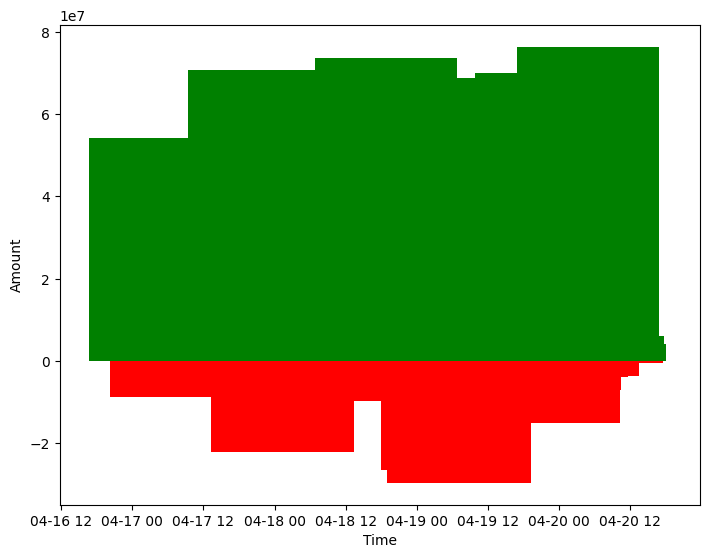

In [16]:
if (mint_events and burn_events):
    datetime_data = []
    mint_events_data = []
    burn_events_data = []
    # Prepare data points
    for event in mint_events:
        datetime_data.append(datetime.fromtimestamp(event['timestamp']))
        mint_events_data.append(fromUnits(event['args']['amount'], TOKEN_DECIMALS))
        burn_events_data.append(0)

    for event in burn_events:
        datetime_data.append(datetime.fromtimestamp(event['timestamp']))
        mint_events_data.append(0)
        burn_events_data.append(-fromUnits(event['args']['amount'], TOKEN_DECIMALS))
    # Create chart
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(datetime_data, mint_events_data, width=1, color='g')
    ax.bar(datetime_data, burn_events_data, width=1, color='r')
    plt.xlabel("Time")
    plt.ylabel("Amount")
    plt.show()

### Fetching new Mint and Burn events

In [ ]:
# Constants
BATCH_SIZE = 1000
# Variables
new_mint_events = []
new_burn_events = []
last_mint_block_num = None
last_burn_block_num = None
current_block_num = w3.eth.blockNumber

# Start from the last recorded event blockNumber or from the token creation block
if (mint_events and burn_events):
    if mint_events[-1]['blockNumber'] > burn_events[-1]['blockNumber']:
        last_block_num = mint_events[-1]['blockNumber'] + 1
    else:
        last_block_num = burn_events[-1]['blockNumber'] + 1
else:
    last_block_num = TOKEN_CREATION_BLOCK
# Setup progress bar
pbar = tqdm(total=current_block_num - last_block_num)

# Run loop until the most recent block on the chain
while last_block_num <= current_block_num:
    events = fetch_chunk(contract.events.Mint, last_block_num, last_block_num + BATCH_SIZE - 1)
    for event in events:
        # Retrieve event timestamp
        timestamp = get_block_timestamp(event.blockNumber)
        # Add event in array
        new_mint_events.append({
            'args': dict(event.args),
            'blockNumber': event.blockNumber,
            'timestamp': timestamp}
        )

    events = fetch_chunk(contract.events.Burn, last_block_num, last_block_num + BATCH_SIZE - 1)
    for event in events:
        # Retrieve event timestamp
        timestamp = get_block_timestamp(event.blockNumber)
        # Add event in array
        new_burn_events.append({
            'args': dict(event.args),
            'blockNumber': event.blockNumber,
            'timestamp': timestamp}
        )

    # Update last_block_num
    last_block_num += BATCH_SIZE
    # Update progress bar
    pbar.update(BATCH_SIZE)

pbar.close()

### Saving events to JSON files

In [ ]:
with open('mint_events.json', 'w+') as fp:
    json.dump(mint_events + new_mint_events, fp)

with open('burn_events.json', 'w+') as fp:
    json.dump(burn_events + new_burn_events, fp)